<a href="https://colab.research.google.com/github/OriJor/Colorization_AI/blob/main/Pix2Pix_Colorization_Last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install wget             # to install the wget library in order to download data
!pip install pytorch-msssim
!pip install lpips

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=bc26fcc03d125623a77400ed75899d227500a3d456929389cb395cb44f28df2d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
import os
import torch
import wget
import zipfile
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from pytorch_msssim import ssim
import time
import math
import lpips





In [ ]:
torch.manual_seed(10)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [ ]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(2.0 / torch.sqrt(mse))


#General Configuration


In [ ]:
# Here the parameters are stored so they can be changed to experiment with its performance
# to change the optimizer algorithm or the model refer to function "train_model(config):"

config = {
   "lr": 1e-04,
   "lr_D": 1e-4,
    "batch_size": 16,
    "epochs": 30,
    "input_channels": 1,
    "output_channels": 2,
    "n_down": 2,
    "num_filters": 64,
    "PATH": 'model_weights',
    "SIZE_X": 192,
    "SIZE_Y": 224,
    "lambda_geo": 10,
    "MSE_Loss": True,
    "LPIPS_alpha": 0,
    "L1_Loss": False,
    "Huber_Loss": False,
    "device": device,
    "gan_mode": 'vanilla', #'lsgan', 'wgan' and 'vanilla
    "gradient_penalty_weight":10,
    "generator": 'unet', #'unet', 'resnet'
    "discriminador": 'patch' #'patch',  'pixel', 'critic' (works well with wgan)'

    }

#RGB Transformations


The CIELAB color space, also referred to as L*a*b*, is a color space defined by the International Commission on Illumination (abbreviated CIE) in 1976.[a] It expresses color as three values: L* for perceptual lightness and a* and b* for the four unique colors of human vision: red, green, blue and yellow. CIELAB was intended as a perceptually uniform space, where a given numerical change corresponds to a similar perceived change in color. While the LAB space is not truly perceptually uniform, it nevertheless is useful in industry for detecting small differences in color.


The lightness value, L*, also referred to as "Lstar," defines black at 0 and white at 100. The a* axis is relative to the green–magenta opponent colors, with negative values toward green and positive values toward magenta. The b* axis represents the blue–yellow opponents, with negative numbers toward blue and positive toward yellow.


The a* and b* axes are unbounded and depending on the reference white they can easily exceed ±150 to cover the human gamut. Nevertheless, software implementations often clamp these values for practical reasons. For instance, if integer math is being used it is common to clamp a* and b* in the range of −128 to 127.


*lab_to_rgb(L,ab*) supposes that L and ab are between -1 and 1. As ab is the output of our Network, we would use a tanh(x) as the activation function for our output layer.

In [ ]:
def scale_image_lab_to_rgb(L, ab):
  L = (L + 1.)*50.
  ab = ab* 110.
  return L, ab

In [ ]:
def scale_image_to_nn_input(L, ab):
   L = L / 50. - 1.
   ab = ab/110.
   return L, ab

In [ ]:
def xyz2rgb(xyz):
    # array([[ 3.24048134, -1.53715152, -0.49853633],
    #        [-0.96925495,  1.87599   ,  0.04155593],
    #        [ 0.05564664, -0.20404134,  1.05731107]])

    r = 3.24048134*xyz[:,0,:,:]-1.53715152*xyz[:,1,:,:]-0.49853633*xyz[:,2,:,:]
    g = -0.96925495*xyz[:,0,:,:]+1.87599*xyz[:,1,:,:]+.04155593*xyz[:,2,:,:]
    b = .05564664*xyz[:,0,:,:]-.20404134*xyz[:,1,:,:]+1.05731107*xyz[:,2,:,:]

    rgb = torch.cat((r[:,None,:,:],g[:,None,:,:],b[:,None,:,:]),dim=1)
    rgb = torch.max(rgb,torch.zeros_like(rgb)) # sometimes reaches a small negative number, which causes NaNs

    mask = (rgb > .0031308).type(torch.FloatTensor)
    if(rgb.is_cuda):
        mask = mask.cuda()

    rgb = (1.055*(rgb**(1./2.4)) - 0.055)*mask + 12.92*rgb*(1-mask)

    # if(torch.sum(torch.isnan(rgb))>0):
        # print('xyz2rgb')
        # embed()
    return rgb

In [ ]:
def xyz2lab(xyz):
    # 0.95047, 1., 1.08883 # white
    sc = torch.Tensor((0.95047, 1., 1.08883))[None,:,None,None]
    if(xyz.is_cuda):
        sc = sc.cuda()

    xyz_scale = xyz/sc

    mask = (xyz_scale > .008856).type(torch.FloatTensor)
    if(xyz_scale.is_cuda):
        mask = mask.cuda()

    xyz_int = xyz_scale**(1/3.)*mask + (7.787*xyz_scale + 16./116.)*(1-mask)

    L = 116.*xyz_int[:,1,:,:]-16.
    a = 500.*(xyz_int[:,0,:,:]-xyz_int[:,1,:,:])
    b = 200.*(xyz_int[:,1,:,:]-xyz_int[:,2,:,:])
    out = torch.cat((L[:,None,:,:],a[:,None,:,:],b[:,None,:,:]),dim=1)

    # if(torch.sum(torch.isnan(out))>0):
        # print('xyz2lab')
        # embed()

    return out


In [ ]:
def lab2xyz(lab):
    y_int = (lab[:,0,:,:]+16.)/116.
    x_int = (lab[:,1,:,:]/500.) + y_int
    z_int = y_int - (lab[:,2,:,:]/200.)
    if(z_int.is_cuda):
        z_int = torch.max(torch.Tensor((0,)).cuda(), z_int)
    else:
        z_int = torch.max(torch.Tensor((0,)), z_int)

    out = torch.cat((x_int[:,None,:,:],y_int[:,None,:,:],z_int[:,None,:,:]),dim=1)
    mask = (out > .2068966).type(torch.FloatTensor)
    if(out.is_cuda):
        mask = mask.cuda()

    out = (out**3.)*mask + (out - 16./116.)/7.787*(1-mask)

    sc = torch.Tensor((0.95047, 1., 1.08883))[None,:,None,None]
    sc = sc.to(out.device)

    out = out*sc

    # if(torch.sum(torch.isnan(out))>0):
        # print('lab2xyz')
        # embed()

    return out

In [ ]:
def rgb2xyz(rgb): # rgb from [0,1]
    # xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
        # [0.212671, 0.715160, 0.072169],
        # [0.019334, 0.119193, 0.950227]])

    mask = (rgb > .04045).type(torch.FloatTensor)
    if(rgb.is_cuda):
        mask = mask.cuda()

    rgb = (((rgb+.055)/1.055)**2.4)*mask + rgb/12.92*(1-mask)

    x = .412453*rgb[:,0,:,:]+.357580*rgb[:,1,:,:]+.180423*rgb[:,2,:,:]
    y = .212671*rgb[:,0,:,:]+.715160*rgb[:,1,:,:]+.072169*rgb[:,2,:,:]
    z = .019334*rgb[:,0,:,:]+.119193*rgb[:,1,:,:]+.950227*rgb[:,2,:,:]
    out = torch.cat((x[:,None,:,:],y[:,None,:,:],z[:,None,:,:]),dim=1)
    return out

In [ ]:
def rgb2lab(rgb):
    lab = xyz2lab(rgb2xyz(rgb))
    l_rs = (lab[:,[0],:,:]-50)/100
    ab_rs = lab[:,1:,:,:]/110
    out = torch.cat((l_rs,ab_rs),dim=1)
    return out

In [ ]:
def lab_to_rgb(L, ab):
    """
    Function to return LAB encoded images to RGB format
    """
    L , ab = scale_image_lab_to_rgb(L, ab)

    is_not_batch = len(L.shape) == 3

    if  is_not_batch:
      L = L.unsqueeze(dim=0)
      ab = ab.unsqueeze(dim=0)

    lab = torch.cat((L,ab),dim=1)
    out = xyz2rgb(lab2xyz(lab))

    if is_not_batch:
      out = out.squeeze(dim=0).permute(1,2,0)

    return out

In [ ]:
l = torch.ones(16, 1, 224, 224)
ab = torch.ones(16, 2, 224, 224)

rgb = lab_to_rgb(l, ab)



#Dataset Loading and transformation


In [ ]:
#the name given to the folder were our dataset is going to be stored
data_root = "datasets"

# the source url from wich the training data will be provided in this case celebA
base_url = "https://graal.ift.ulaval.ca/public/celeba/"

#the list of files that are going to be downloaded
file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

# Download files from the internet reading file for file and checking if it indeed exists already and if not downloading it
for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

# Opening in read mode teh zip file of the celbrities images
with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
  for file in ziphandler.namelist()[:50000]:
    ziphandler.extract(file, dataset_folder)


In [ ]:
#the complete path to the images once dwnloaded is saved in images_path by using os.path.join that makes it compatible independently of the os
images_path = os.path.join(data_root, "celeba/img_align_celeba")
print(images_path)

datasets/celeba/img_align_celeba


In [ ]:
class MyDataset(Dataset):
    """
    A custom dataset class for loading image paths from a given directory.
    """

    def __init__(self, data_directory, transform=None):
        """
        Initializes the dataset instance.

        Args:
        - data_directory (str): The directory containing the dataset.
        - transform (callable, optional): A function/transform to be applied on the image paths. Default is None.
        """
        super().__init__()

        self.directory = data_directory
        self.transform = transform
        self.add_all_image_paths()

    def __len__(self):
        """
        Returns the total number of image paths in the dataset.
        """
        return len(self.paths)

    def __getitem__(self, idx):
        """
        Returns the image path at the given index.
        """
        return self.paths[idx]

    def add_all_image_paths(self):
        """
        Adds all the image paths recursively from the dataset directory which come from an argument in the __init__ function of the class.
        """
        # here the list where all the paths to images will be stored is created
        self.paths = []
        # here the function that recursively adds all paths starting from the main one data_directory
        self.add_all_image_paths_from_directory(self.directory)

    def add_all_image_paths_from_directory(self, path):
        """
        Recursively adds all the image paths from the given directory and its subdirectories.

        Args:
        - path (str): The path of the directory to search for image paths.
        """
        # definition of the function that checks if it's a directory (which would mean it's needed to go into it) and if it's an image, call the function to add it to the list paths
        if os.path.isdir(path):
            for filename in os.listdir(path):
                self.add_all_image_paths_from_directory(os.path.join(path, filename))
        else:
            self.add_image_path(path)

    def add_image_path(self, path):
        """
        Adds the given image path to the list of image paths.

        Args:
        - path (str): The path of the image file to be added.
        """
        # the function to add the paths to images to our list
        if os.path.exists(path):
            self.paths.append(path)

In [ ]:
class DatasetFromSubset(Dataset):
  """
  Custom class meant to be executed after the class my dataset with its correspondent transforms has been called
  args:
  - Dataset: A subset of a prepared dataset using mydataset class and a "transforms.Compose" method

  """
  def __init__(self, subset, transform=None):
      # Assignation of variables
        self.subset = subset
        self.transform = transform
        # here the first images is transformed and the first image shape is called to get the channel index of an RGB image
        self.image_channel_axis = self.get_image(self.subset[0]).shape.index(3)
        # we assign channel axis to index 2 because rgb2lab will need the channel in said pposition
        self.channel_axis = 2

  def get_image(self, path):
      #function to convert image to RGB, transform to tensor and then transform to numpy array
        img =  Image.open(path).convert("RGB")
        img = self.transform(img)
        img = np.array(img)
        return img

  def __getitem__(self, index):
      # First img is selected and transformed using get_image which is commented above, then our channel axis is moved to position 2 because rgb2lab expects it in that position
      # img is transformed to LAB encoding with float32 values
      # channel 0 (Lightness) is assigned to L
      # channles 1 and 2 are assigned to ab
        path = self.subset[index]
        img = self.get_image(path)
        img = np.moveaxis(img, self.image_channel_axis, self.channel_axis)
        img = transforms.ToTensor()(img).unsqueeze(dim=0)
        img_lab = rgb2lab(img).squeeze(dim=0) # Converting RGB to L*a*b

        L = img_lab[[0], ...]
        ab = img_lab[[1, 2], ...]

        return {'L': L, 'ab': ab, 'path':path}

  def __len__(self):
        return len(self.subset)

In [ ]:
#transformations necessary to convert an RGB image to a Tensor and data augmentation performed
# Done using torch cunction transforms.Compose to be able to do them on the fly

train_transform = transforms.Compose([
        transforms.Resize((config["SIZE_X"], config["SIZE_Y"]),  Image.BICUBIC),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip()])
test_transform =  transforms.Compose([
        transforms.Resize((config["SIZE_X"], config["SIZE_Y"]),  Image.BICUBIC),
        transforms.ToTensor(),
        ])


In [ ]:
# complete path to the images joined including the folder where they where stored
images_path = os.path.join(data_root, "celeba/img_align_celeba")

# using complete path a list to the individual images through its paths is compiled using MyDataset method commented above
image_dataset = MyDataset(images_path, transform = test_transform)

#Legth of the dataset calculated to then separate our train, test and validation using its index position
dataset_size = len(image_dataset)
print(dataset_size)
# test and validation sizes calculated 15% of the dataset each
test_size, val_size = int(0.15 * dataset_size), int(0.15 * dataset_size)
# train size calculated using the remainder after the other subsets are accounted for
train_size = dataset_size - val_size - test_size

# using torch utils teh dataset can be separated giving only our data and the sizes of our diferent subsets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, test_size, val_size])







49999


In [ ]:
#  here the datasets are further reduced due to computing power constrictions and transformed to LAB.
train_subset = DatasetFromSubset(Subset(train_dataset, np.arange(1, 5000)), train_transform)
val_subset = DatasetFromSubset(Subset(val_dataset, np.arange(1, 2000)), test_transform)
test_subset = DatasetFromSubset(Subset(test_dataset, np.arange(1, 2000)), test_transform)

# the dataloader is called with suffle enabled so data has not the same order every epoch
train_dataloader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=config["batch_size"], shuffle=False)

#Data Visualization

In [ ]:
def display_rgb_image(data_image):
  """
  function to plot images from RGB
  """
  rgb_image = lab_to_rgb(data_image['L'], data_image['ab'])
  plt.imshow(rgb_image)

In [ ]:
def display_rgb_image_subplot(data_image, ax ):
  """

  """
  rgb_image = lab_to_rgb(data_image['L'], data_image['ab']).cpu().detach().numpy()
  ax.imshow(rgb_image)

In [ ]:
def display_grayscale_image_subplot(data_image, ax ):
  grayscale_image = data_image['L'].permute( 1, 2, 0).cpu().numpy()
  ax.imshow(grayscale_image, cmap = 'gray')

Shape of grayscale image:  torch.Size([1, 192, 224])
Shape of AB image:  torch.Size([2, 192, 224])
datasets/celeba/img_align_celeba/048607.jpg


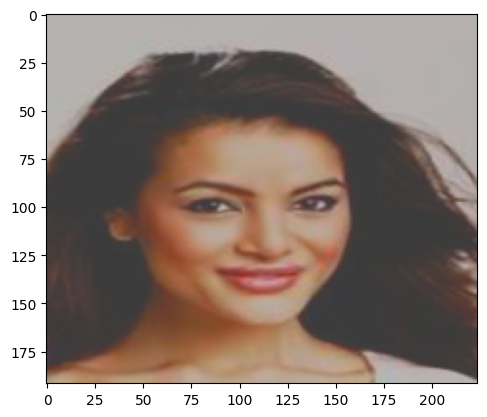

In [ ]:
test_image = test_subset[2]

print('Shape of grayscale image: ', test_image['L'].shape)
print('Shape of AB image: ', test_image['ab'].shape)
print(test_subset.subset[10])

display_rgb_image(test_image)


In [ ]:
def visualize_image_set(test_loader, model, images_number = 3, save = False):
   with torch.no_grad():
      test_data_images = next(iter(test_loader))
      visualize(test_data_images, model, images_number, save)

In [ ]:
def visualize(test_data_images, model, images_number = 3, save = False):
   with torch.no_grad():
      grayscale_images = test_data_images['L'][:images_number, ...].to(device)
      output_images = model(grayscale_images).cpu()

      L_images = [test_data_images['L'][i, ...] for i in range(images_number)]
      ab_images = [test_data_images['ab'][i, ...].squeeze(dim =0) for i in range(images_number)]

      images = {'input_L': L_images, 'ground_truth_ab': ab_images, 'output_ab': output_images}
      fig = plt.figure(figsize = (15, 5*images_number))
      gs = fig.add_gridspec(3, images_number, hspace=0, wspace=0)
      axs = gs.subplots(sharex=True, sharey=True)
      if axs.ndim == 1:
        axs = np.expand_dims(axs, axis=1)




      for index in range(images_number):
        output_image = {'L': images['input_L'][index], 'ab': images['output_ab'][index]}
        gt_image = {'L': images['input_L'][index], 'ab': images['ground_truth_ab'][index]}

        shift = index * 3
        axs[0, index] = plt.subplot(images_number, 3, 1 + shift)
        display_grayscale_image_subplot(output_image, axs[0, index])

        axs[1, index]  = plt.subplot(images_number,3, 2 + shift)
        display_rgb_image_subplot(output_image, axs[1, index])

        axs[2, index] = plt.subplot(images_number,3,3 + shift)
        display_rgb_image_subplot(gt_image, axs[2, index])

      axs[0, 0].set_title("GrayScale Image")
      axs[1, 0].set_title("Output Image")
      axs[2, 0].set_title("Ground-Truth Image")
      for ax in fig.get_axes():
        ax.label_outer()
        ax.axis('off')
      plt.show()
      if save:
        fig.savefig("colorization.png")


#MODEL

##Unet

The architecture gets its name from its U-shaped structure, which consists of an encoding path (down-convolution path) and a decoding path (up-convolution path). Let's dive into the details of each part:

**Encoding Path:**


The encoding path takes the input image and gradually reduces its spatial dimensions while increasing the number of feature channels. It captures high-level abstract representations and context information. The main components of the encoding path are:
Down-Convolution: Each down-convolution step consists of a convolutional layer, followed by an activation function such as LeakyReLU, and a normalization layer such as Batch Normalization. These operations help to extract features and introduce non-linearity in the network.
Max Pooling: After each down-convolution step, a max pooling operation with a kernel size of 2x2 is performed to reduce the spatial dimensions of the feature maps.

**Decoding Path:**

The decoding path takes the feature maps from the encoding path and gradually upsamples them back to the original input size while reducing the number of channels. It helps to recover spatial details and refine the segmentation masks. The main components of the decoding path are:
Up-Convolution: Each up-convolution step consists of an upsampling operation, often achieved through transposed convolution (also known as deconvolution). This operation increases the spatial dimensions while reducing the number of channels.
Concatenation: At each up-convolution step, the feature maps from the corresponding down-convolution step in the encoding path are concatenated with the upsampled feature maps. This skip-connection helps to preserve fine-grained details from the encoding path.
Convolution: After concatenation, a regular convolutional layer is applied to refine the combined feature maps.
Dropout: In some variations of UNet, dropout layers are introduced to prevent overfitting during training.


**Final Layers:**


The final layers of the UNet architecture map the refined feature maps to the desired output. Typically, a 1x1 convolution is used to reduce the number of channels to the desired number of output classes (e.g., for semantic segmentation). The activation function used in the final layer depends on the specific task. For example, in binary segmentation, a sigmoid activation is often used, while for multi-class segmentation, a softmax activation is commonly employed.
The UNet architecture is symmetric, with the number of channels gradually increasing and then decreasing in the encoding and decoding paths, respectively. This allows the model to capture both local and global information effectively. Additionally, the skip-connections between corresponding layers in the encoding and decoding paths help to bridge the gap between low-level and high-level features, enabling precise segmentation results.


Overall, the UNet architecture has been widely adopted and achieved excellent performance in various image segmentation tasks, making it a popular choice among researchers and practitioners.

Unet Model:

The architecture is implemented using two main classes: UnetBlock and Unet.

The UnetBlock class represents a single block in the UNet architecture. Each block consists of a down-convolution path and an up-convolution path. The down-convolution path reduces the spatial dimensions of the input while increasing the number of channels, and the up-convolution path upsamples the feature maps back to the original size while decreasing the number of channels. Each block also performs normalization and activation operations.

The Unet class represents the entire UNet model. It takes a configuration dictionary as input, which specifies the number of input and output channels, the number of down-sampling steps (n_down), and the number of filters to use in each block (num_filters).

The Unet class initializes the model by creating the innermost block first, which only performs up-convolution. Then, for each down-sampling step (except the innermost and outermost blocks), it creates a new UnetBlock instance with dropout and sets it as the submodule of the previous block. This creates a hierarchical structure where each block's submodule is the previous block.

After the down-sampling steps, the model creates three additional blocks for up-convolution. The number of output filters for each up-convolution block is halved compared to the previous block.

Finally, the outermost block is created with the specified output channels and the submodule set as the entire UNet structure. This block represents the final output of the model.

The forward method of the Unet class passes the input through the entire UNet structure and returns the output.

In [ ]:
class UnetBlock(nn.Module):
    """
    Base Block of the Unet model
    """
    def __init__(self, nf, ni, submodule=None, input_channels=None, dropout=False,
                 innermost=False, outermost=False, dropout_value = 0.5):
        super().__init__()

        self.outermost = outermost
        if input_channels is None:
            input_channels = nf
        downconv = nn.Conv2d(input_channels, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout:
                up += [nn.Dropout(dropout_value)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, config, dropout_value = 0.5):
        super().__init__()

        self.input_channels = config["input_channels"]
        self.output_channels = config["output_channels"]
        self.n_down = config["n_down"]  # Number of down-sampling steps


        self.num_filters = config["num_filters"]

        unet_block = UnetBlock(self.num_filters * 8, self.num_filters * 8, innermost=True)
        for _ in range(self.n_down - 5):
            unet_block = UnetBlock(self.num_filters * 8, self.num_filters * 8, submodule=unet_block, dropout=True, droput_value = droput_value)
        output_filters = self.num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(output_filters // 2, output_filters, submodule=unet_block)
            output_filters //= 2
        self.model = UnetBlock(self.output_channels, output_filters, input_channels=self.input_channels, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

##RESNET

In [ ]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [ ]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, config, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        super().__init__()
        self.input_channels = config["input_channels"]
        self.output_channels = config["output_channels"]
        self.n_down = config["n_down"]
        self.num_filters = config["num_filters"]
        """Construct a Resnet-based generator
         Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(self.input_channels, self.num_filters, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(self.num_filters),
                 nn.ReLU(True)]
        n_downsampling = 2

        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(self.num_filters * mult, self.num_filters * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(self.num_filters * mult * 2),
                      nn.ReLU(True)]
        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
          model += [ResnetBlock(self.num_filters * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(self.num_filters * mult, int(self.num_filters * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(self.num_filters * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(self.num_filters, self.output_channels, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

#Discriminator


##Patch Discriminator

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_channels, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

##Critic Discriminator

In [ ]:
class CriticDiscriminator(nn.Module):
  def __init__(self, input_channels, num_filters=64, n_down=3):
     super().__init__()
     model = [self.get_layers(input_channels, num_filters, norm=False)]
     model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
     model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
     model += [nn.Flatten(), nn.Linear(22*26, 1)]

     self.model = nn.Sequential(*model)
  def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
    layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
    if norm: layers += [nn.BatchNorm2d(nf)]
    if act: layers += [nn.LeakyReLU(0.2, True)]
    return nn.Sequential(*layers)
  def forward(self, x):
        return self.model(x)



In [ ]:
PatchDiscriminator(3).modules()

AttributeError: ignored

In [ ]:
CriticDiscriminator(3)

CriticDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    

##Pixel Discriminator

In [ ]:
class PixelDiscriminator(nn.Module):
   """Construct a 1x1 PatchGAN discriminator"""
   def __init__(self, input_channels, num_filters=64):
    super().__init__()
    layers = [
            nn.Conv2d(input_channels, num_filters, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_filters * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(num_filters * 2, 1, kernel_size=1, stride=1, padding=0, bias=False)]

    self.model = nn.Sequential(*layers)

   def forward(self, x):
    return self.model(x)


#Generator and Discriminator Wrappers

##Discriminator

In [ ]:
class Discriminador(nn.Module):
  def __init__(self, config,  input_channels = 3, num_filters=64):
    super().__init__()
    discriminator_name = config["discriminador"]
    if discriminator_name == "patch":
      self.discriminator = PatchDiscriminator(input_channels, num_filters, n_down= 3)
    elif discriminator_name == "critic":
      self.discriminator = CriticDiscriminator(input_channels, num_filters, n_down= 3)
    elif discriminator_name == "pixel":
      self.discriminator = PixelDiscriminator(input_channels,num_filters )
  def forward(self, x):
    return self.discriminator(x)

In [ ]:
discriminator = Discriminador(config)
dummy_input = torch.randn(config["batch_size"], 3, config["SIZE_X"], config["SIZE_Y"]) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 22, 26])

In [ ]:
discriminator = CriticDiscriminator(3)
discriminator

CriticDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    

In [ ]:
discriminator_size = (3,  192, 224)  # Assuming 3 channel (grayscale image) and size (256x256)
print("Distributor: ")
# Print the model summary
summary(discriminator, input_size=discriminator_size, device=device_str)

Distributor: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 96, 112]           3,136
         LeakyReLU-2          [-1, 64, 96, 112]               0
            Conv2d-3          [-1, 128, 48, 56]         131,072
       BatchNorm2d-4          [-1, 128, 48, 56]             256
         LeakyReLU-5          [-1, 128, 48, 56]               0
            Conv2d-6          [-1, 256, 24, 28]         524,288
       BatchNorm2d-7          [-1, 256, 24, 28]             512
         LeakyReLU-8          [-1, 256, 24, 28]               0
            Conv2d-9          [-1, 512, 23, 27]       2,097,152
      BatchNorm2d-10          [-1, 512, 23, 27]           1,024
        LeakyReLU-11          [-1, 512, 23, 27]               0
           Conv2d-12            [-1, 1, 22, 26]           8,193
          Flatten-13                  [-1, 572]               0
           Linear-14     

##Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, config):
    super().__init__()
    generator_name = config["generator"]
    if generator_name == "unet":
      self.generator = Unet(config)
    elif generator_name == "resnet":
      self.generator = ResnetGenerator(config)

  def forward(self, x):
    return self.generator(x)

In [ ]:
Generator(config)

#GAN Model

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, config, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.gan_mode = config["gan_mode"]

        if self.gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif self.gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif self.isWGAN():
          self.loss = None
    def isWGAN(self):
      return self.gan_mode == 'wgan'

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def wgan_loss(self,prediction, target_is_real):
      if target_is_real:
        return -torch.mean(prediction)
      else:
        return torch.mean(prediction)

    def __call__(self, preds, target_is_real):
        if self.isWGAN():
          return self.wgan_loss(preds, target_is_real)
        else:
          labels = self.get_labels(preds, target_is_real)
          loss = self.loss(preds, labels)
        return loss

    def gradient_penalty_loss(self, model, gradient_penalty_weight):
        weights = torch.randn((model.ab.size(0),1,1,1), device=model.device)
        averaged_samples = (weights * model.ab ) + ((1 - weights) * model.fake_color)
        averaged_samples = torch.autograd.Variable(averaged_samples, requires_grad=True)
        avg_img = torch.cat([model.L, averaged_samples], dim=1)
        avg_pred = model.net_D(avg_img)

        return self.gradient_penalty(avg_pred, averaged_samples,gradient_penalty_weight)

    def gradient_penalty(self,y_pred, averaged_samples, gradient_penalty_weight):

      gradients = torch.autograd.grad(y_pred,averaged_samples,
                              grad_outputs=torch.ones(y_pred.size(), device=device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
      gradients = gradients.view(gradients.size(0), -1)
      gradient_penalty = (((gradients+1e-16).norm(2, dim=1) - 1) ** 2).mean() * gradient_penalty_weight
      return gradient_penalty

In [ ]:
def geometric_criterion(config):
     if config["MSE_Loss"]:
      return torch.nn.MSELoss()
     elif config["L1_Loss"]:
      return torch.nn.L1Loss()
     elif config["Huber_Loss"]:
      return torch.nn.HuberLoss()

In [ ]:
class GAN(nn.Module):
    def __init__(self, config, net_G=None, beta1=0.5, beta2=0.999):
        super().__init__()

        self.device = config["device"]
        lr_G = config["lr"]
        lr_D = config["lr_D"]
        self.lambda_geo = config["lambda_geo"]


        if net_G is None:
            self.net_G = init_model(Generator(config), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(Discriminador(config), self.device)
        self.GANcriterion = GANLoss(config).to(self.device)
        self.geometric_criterion = geometric_criterion(config)
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))




    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)


    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        if self.GANcriterion.isWGAN():
          self.loss_D += self.GANcriterion.gradient_penalty_loss(self, config["gradient_penalty_weight"])*0.5

        self.loss_D.backward()

    def backward_G(self, lpips_net):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.compute_metrics(lpips_net)
        self.loss_G = self.loss_G_GAN + self.loss_G_geometric + self.loss_G_Lpips
        self.loss_G.backward()

    def compute_lpips_loss(self, lpips_net):
      if lpips_net is None:
        self.loss_G_Lpips = torch.zeros(1).to(self.device)
        return None

      pred_images =lab_to_rgb(self.L, self.fake_color)
      #transform the images back to a format acceptable for lpips loss
      pred_images = pred_images.to(device)
      gt = lab_to_rgb(self.L, self.ab).to(device)
      lpips_value = lpips_net(pred_images, gt)
      self.loss_G_Lpips = config["LPIPS_alpha"] * lpips_value.mean()

    def evaluate(self, lpips_net):
      with torch.no_grad():
        self.forward()
        self.compute_metrics(lpips_net)

    def compute_metrics(self, lpips_net):
       self.loss_G_geometric = self.geometric_criterion(self.fake_color, self.ab) * self.lambda_geo
       self.compute_lpips_loss(lpips_net)
       self.computePSNR()
       self.computeSSIM()

    def computePSNR(self):
      psnr_metric = PSNR()
      self.psnr = psnr_metric(self.fake_color, self.ab)
    def computeSSIM(self):
      self.ssim = ssim(self.fake_color,  self.ab, data_range=2.0, size_average=True)

    def optimize(self, lpips_net):
        self.forward()

        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()


        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G(lpips_net)
        self.opt_G.step()

#Save and initialize weights

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net



In [ ]:
def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

#Metrics


In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

In [ ]:
class ValidationMetrics():
  def __init__(self, training = False):
    self.loss_dict = {"loss_D": [],
                 "loss_D_fake": [],
                 "loss_D_real": [],
                 "loss_G_GAN": [],
                 "loss_G":[],
                 }
    self.metric_dict = {"loss_G_geometric":[],
                 "loss_G_Lpips": [],
                  "ssim":[],
                  "psnr":[],
                   }
    self.metric_logic = {"loss_G_geometric":True,
                 "loss_G_Lpips": True,
                  "ssim":False,
                  "psnr":False,
                   }
    self.training = training
    self.min_eval_loss = None
    self.metric_weights = {"loss_G_geometric": 20, "loss_G_Lpips": 10, "ssim": 2, "psnr": 0.05}


  def printValues(self, epoch = 0):
    if self.training:
      print("Training results: ")
    else:
      print("Validation results: ")
    print(f"Epoch {epoch}")
    self.log_results(epoch) # function to print out the losses

  def add(self, loss_meter_dict, metric_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
      self.loss_dict[loss_name].append(loss_meter.avg)


    for metric_name, metric_meter in metric_meter_dict.items():
        self.metric_dict[metric_name].append(metric_meter.avg)

  def average_metric(self,epoch):
    metrics = [self.compute_metric(metric_name, weight, epoch) for metric_name, weight in self.metric_weights.items()]
    return np.mean(metrics)

  def compute_metric(self, metric_name, weight, epoch ):
    is_lower_the_better = self.metric_logic[metric_name]

    if is_lower_the_better:
      return weight * self.metric_dict[metric_name][epoch]
    else:
      return  weight / self.metric_dict[metric_name][epoch]


  def save_weights(self, model, epoch, path):

    eval_loss = self.average_metric(epoch)
    if self.min_eval_loss is None:
      self.min_eval_loss = eval_loss
      save_model(model, path)
    elif eval_loss < self.min_eval_loss:
      self.min_eval_loss = eval_loss
      save_model(model, path)

  def log_results(self, epoch):
    if self.training:
      for loss_name, loss_meter in self.loss_dict.items():
          print(f"{loss_name}: {loss_meter[epoch]:.5f}")
    for metric_name, metric_meter in self.metric_dict.items():
        print(f"{metric_name}: {metric_meter[epoch]:.5f}")

  def update_losses(self,model, loss_meters_dictionary, count):
    if self.training:
      for loss_name, loss_meter in loss_meters_dictionary.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

  def update_metrics(self,model, metrics_meters_dictionary, count):
    for metric_name, metric_meter in metrics_meters_dictionary.items():
      metric = getattr(model, metric_name)
      metric_meter.update(metric.item(), count=count)

  def create_loss_meters(self):
    loss_meters_dictionary = {}
    for loss_name in self.loss_dict:

      loss_meters_dictionary[loss_name] = AverageMeter()
    return loss_meters_dictionary
  def create_metric_meters(self):
    metric_meters_dictionary = {}
    for metric_name in self.metric_dict:
      metric_meters_dictionary[metric_name] = AverageMeter()
    return metric_meters_dictionary

  def save_metrics(self, path = 'data.csv'):

    headers = ['Epoch']
    number_epochs = max([len(values) for  values in self.metric_dict.values()])

    if self.training:
      headers += list(self.loss_dict.keys())
    headers += list(self.metric_dict.keys())

    lines = []

    for epoch in range(number_epochs):
      metric_values = [epoch]
      if self.training:
          metric_values += [values[epoch] for values in  self.loss_dict.values()]
      metric_values += [values[epoch] for values in  self.metric_dict.values()]
      lines.append(metric_values)



    np.savetxt(path,lines, header = ','.join(headers),  delimiter=',')

Get the loss stated in configuration

Activate LPIPS or not based on configuration

In [ ]:
use_LPIPS = config["LPIPS_alpha"] > 0
if use_LPIPS:
  lpips_net = lpips.LPIPS(net="vgg").to(device)
  lpips_net.zero_grad()
else:
  lpips_net = None

#Training Functions

Training functions

In [ ]:
def run_single_epoch(loader, model, evaluation_metrics, lpips_net):
    loss_meters_dictionary = evaluation_metrics.create_loss_meters()
    metric_meters_dictionary = evaluation_metrics.create_metric_meters()
    for data in loader:
        model.setup_input(data)
        if model.training:
          model.optimize(lpips_net)
        else:
          model.evaluate(lpips_net)

        evaluation_metrics.update_losses(model, loss_meters_dictionary, count=data['L'].size(0))
        evaluation_metrics.update_metrics(model,metric_meters_dictionary, count=data['L'].size(0))

    evaluation_metrics.add(loss_meters_dictionary,metric_meters_dictionary )



In [ ]:
def train_gan_single_epoch(loader, model, evaluation_metrics, lpips_net):

    model.train()
    return run_single_epoch(loader, model, evaluation_metrics, lpips_net)



In [ ]:
def eval_gan_single_epoch( loader, model, evaluation_metrics, lpips_net = None):

    with torch.no_grad():
        model.eval()
        generator = model.net_G
        visualize_image_set(loader, generator, images_number = 3, save = False)
        return run_single_epoch(loader, model, evaluation_metrics, lpips_net)

In [ ]:
def train_gan_model(config, model, lpips_net):

   training_metrics = ValidationMetrics(training = True)
   evaluation_metrics = ValidationMetrics()
   number_epochs = config["epochs"]


   for epoch in range(number_epochs):
     train_gan_single_epoch(train_dataloader, model, training_metrics, lpips_net)

     training_metrics.printValues(epoch)

     eval_gan_single_epoch(val_dataloader, model, evaluation_metrics , lpips_net)
     evaluation_metrics.printValues(epoch)

     evaluation_metrics.save_weights(model, epoch, config['PATH'])

   return training_metrics, evaluation_metrics


#Training GAN

##Instanciate the model

In [ ]:
generator = init_model(Generator(config), device)
gan_model = GAN(config, net_G = generator)

NameError: ignored

##Summary of the model

In [ ]:
from torchsummary import summary
# Provide a sample input size to the model (e.g., (channels, height, width))
input_size = (1,  192, 224)  # Assuming 1 channel (grayscale image) and size (256x256)

# Convert the device to a string
device_str = str(device)
print("Generator: ")
# Print the model summary
summary(gan_model.net_G, input_size=input_size, device=device_str)
discriminator_size = (3,  192, 224)  # Assuming 3 channel (grayscale image) and size (256x256)
print("Distributor: ")
# Print the model summary
summary(gan_model.net_D, input_size=discriminator_size, device=device_str)

Generator: 
Distributor: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 96, 112]           3,136
         LeakyReLU-2          [-1, 64, 96, 112]               0
            Conv2d-3          [-1, 128, 48, 56]         131,072
       BatchNorm2d-4          [-1, 128, 48, 56]             256
         LeakyReLU-5          [-1, 128, 48, 56]               0
            Conv2d-6          [-1, 256, 24, 28]         524,288
       BatchNorm2d-7          [-1, 256, 24, 28]             512
         LeakyReLU-8          [-1, 256, 24, 28]               0
            Conv2d-9          [-1, 512, 23, 27]       2,097,152
      BatchNorm2d-10          [-1, 512, 23, 27]           1,024
        LeakyReLU-11          [-1, 512, 23, 27]               0
           Conv2d-12            [-1, 1, 22, 26]           8,193
PatchDiscriminator-13            [-1, 1, 22, 26]               0
Total params

In [ ]:
training_parameters, validation_parameters = train_gan_model(config, gan_model, lpips_net)


#Saving the model

In [ ]:
gan_model = GAN(config, net_G = generator)
gan_model.load_state_dict(torch.load(config['PATH']))
gan_model

#Visualize Results

The validation weighted values for each epoch:

In [ ]:
validation_metrics_values = [validation_parameters.average_metric(e) for e in range(config["epochs"])]
validation_metrics_values

[1.9151600167826912,
 1.7609137548850748,
 1.8393538587426816,
 1.9688196333803725,
 1.8848076723362426,
 1.915513172021796,
 1.9802258745837609,
 1.793377924683824,
 1.7497295100427435,
 1.715022239678743,
 1.6161553349084383,
 1.7923176087892987,
 1.7725626257435794,
 2.100095931551816,
 1.710464943696693,
 1.81792113473219,
 2.023153906767519,
 1.6713307679169647,
 1.6922008408985119,
 1.6217191897107426,
 1.764876754031166,
 1.6071636602940207,
 1.6082221702617647,
 1.6313308758641358,
 1.6803135563071583,
 1.7124512423760683,
 1.6330463978018654,
 1.6311380803952924,
 1.6970746326285722,
 1.7311314208073412]

In [ ]:
np.argmin(validation_metrics_values)

21

Visualization of the values

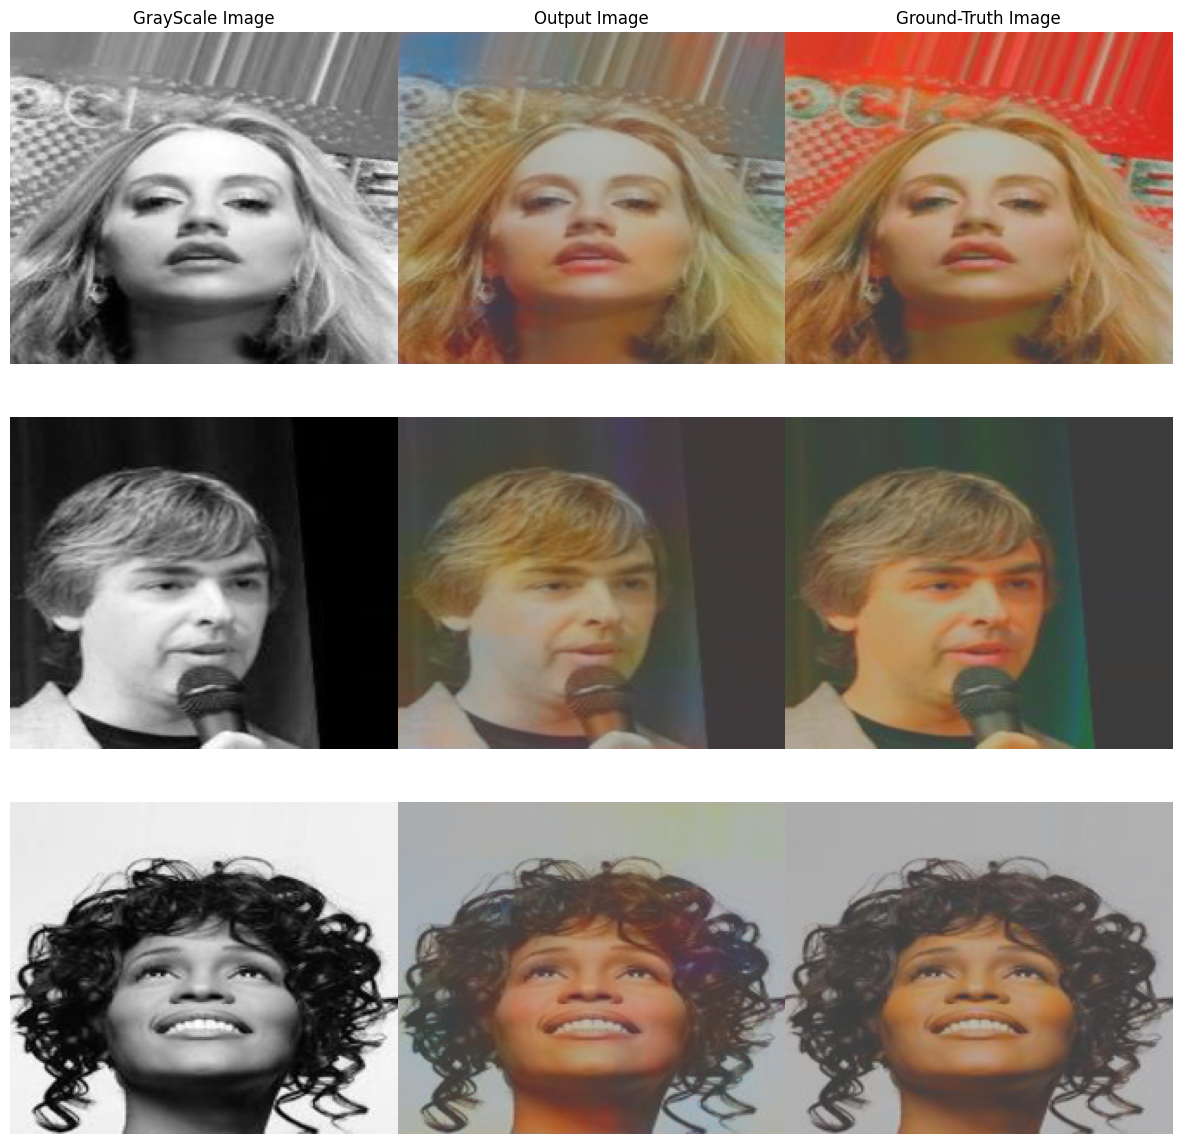

In [ ]:
generator = gan_model.net_G
visualize_image_set(val_dataloader, generator, images_number = 3, save = False)

In [ ]:
gan_model = GAN(config, net_G = generator)
gan_model.load_state_dict(torch.load(config['PATH']))
gan_model

model initialized with norm initialization


GAN(
  (net_G): Generator(
    (generator): Unet(
      (model): UnetBlock(
        (model): Sequential(
          (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (3): UnetBlock(
                    (model): Sequential(
                      (0): LeakyReLU(negative_slope=0.2, inplace=Tr

 Plot the training and validation loss:

<function matplotlib.pyplot.show(close=None, block=None)>

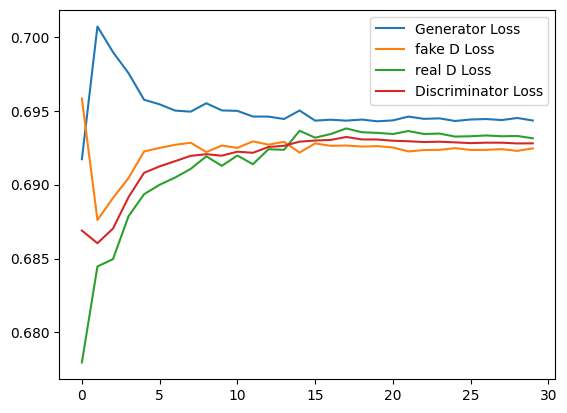

In [ ]:
from matplotlib import pyplot as plt
plt.plot(training_parameters.loss_dict["loss_G_GAN"], label='Generator Loss')
plt.plot(training_parameters.loss_dict["loss_D_fake"], label='fake D Loss')
plt.plot(training_parameters.loss_dict["loss_D_real"],label='real D Loss')
plt.plot(training_parameters.loss_dict["loss_D"],label='Discriminator Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

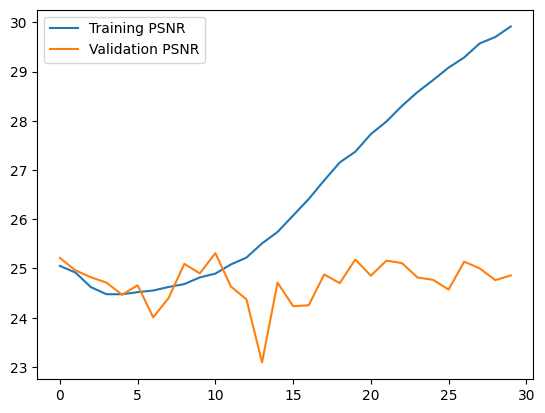

In [ ]:
from matplotlib import pyplot as plt
plt.plot(training_parameters.metric_dict["psnr"], label='Training PSNR')
plt.plot(validation_parameters.metric_dict["psnr"], label='Validation PSNR')
plt.legend()
plt.show

In case you want to skip the model training, you can recuperate the weights and run it from here

<function matplotlib.pyplot.show(close=None, block=None)>

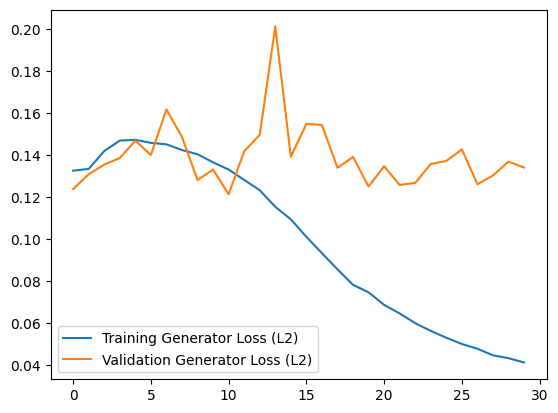

In [ ]:
from matplotlib import pyplot as plt
plt.plot(training_parameters.metric_dict["loss_G_geometric"], label='Training Generator Loss (L2)')
plt.plot(validation_parameters.metric_dict["loss_G_geometric"],label='Validation Generator Loss (L2)')
plt.legend()
plt.show

In [ ]:
from matplotlib import pyplot as plt
if lpips_net is not None:
  plt.plot(training_parameters.metric_dict["loss_G_Lpips"], label='Training LPIPS Loss ')
  plt.plot(validation_parameters.metric_dict["loss_G_Lpips"],label='Validation LPIPS Loss')
  plt.legend()
  plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

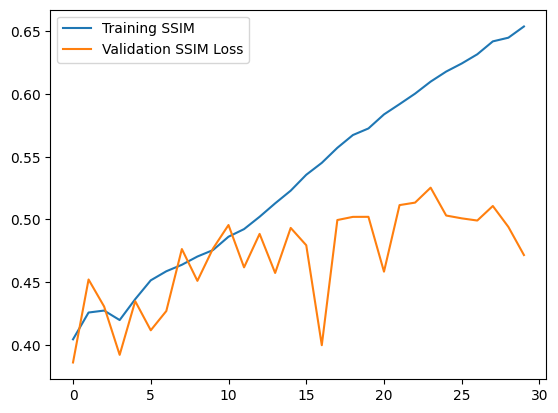

In [ ]:
from matplotlib import pyplot as plt

plt.plot(training_parameters.metric_dict["ssim"], label='Training SSIM')
plt.plot(validation_parameters.metric_dict["ssim"],label='Validation SSIM Loss')
plt.legend()
plt.show

In [ ]:
model = GAN(config, net_G = generator)
model.load_state_dict(torch.load(config['PATH']))
model.eval()

model initialized with norm initialization


GAN(
  (net_G): Generator(
    (generator): Unet(
      (model): UnetBlock(
        (model): Sequential(
          (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (3): UnetBlock(
                    (model): Sequential(
                      (0): LeakyReLU(negative_slope=0.2, inplace=Tr

Testing the model on the test dataset:

In [ ]:
def test_model(model, dataloader):

  test_metrics = ValidationMetrics()
  eval_gan_single_epoch(dataloader, model,test_metrics)
  test_metrics.printValues()

  return test_metrics

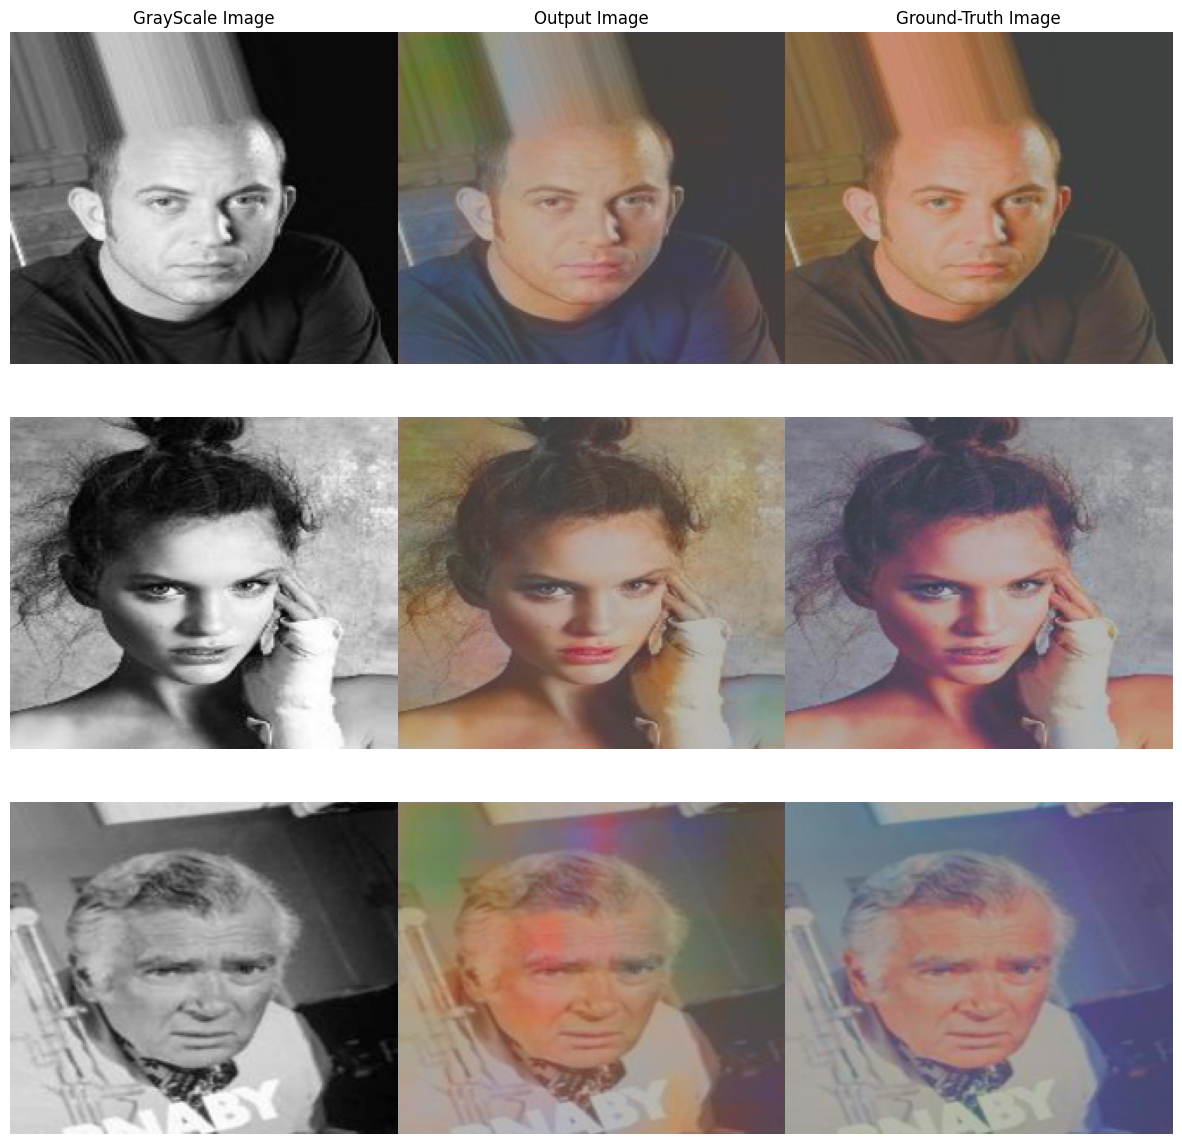

Validation results: 
Epoch 0
loss_G_geometric: 0.13159
loss_G_Lpips: 0.00000
ssim: 0.51238
psnr: 25.01524


In [ ]:
test_model(gan_model, test_dataloader)

#Saving the metrics

In [ ]:
training_parameters.save_metrics( path = 'training_data.csv')
validation_parameters.save_metrics( path = 'validation_data.csv')

#Visualize single image

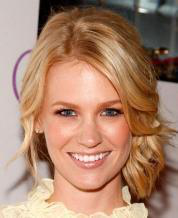

In [ ]:
Image.open("datasets/celeba/img_align_celeba/010714.jpg").convert("RGB")

<ipython-input-102-108aee8d1ac6>:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[0, index] = plt.subplot(images_number, 3, 1 + shift)


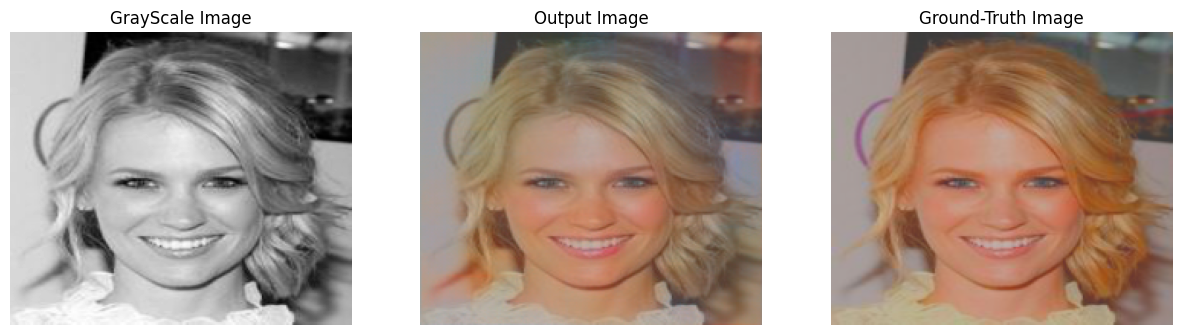

In [ ]:
image_path = "datasets/celeba/img_align_celeba/010714.jpg"
generator = gan_model.net_G
single_image_dataset = MyDataset(image_path, transform = test_transform)
single_image_subset = DatasetFromSubset(Subset(single_image_dataset, np.arange(0,1)) , test_transform)
single_image_dataloader= DataLoader(single_image_subset, batch_size=config["batch_size"], shuffle=False)

visualize_image_set(single_image_dataloader, generator, images_number = 1, save = False)

#Closer image on Dataset

In [ ]:
model_dataset = MyDataset(image_path, transform = test_transform)
model = DatasetFromSubset(Subset(model_dataset, np.arange(0,1)) , test_transform)

psnr = PSNR()
max = 0
complete_database = DatasetFromSubset(image_dataset, test_transform)

complete_dataloader= DataLoader(complete_database, batch_size=config["batch_size"], shuffle=False)

image_model = model[0]['L']
for x, images in enumerate(complete_dataloader):
  L = images['L']
  for index, bnw in enumerate(L):
    value = psnr(bnw, image_model)
    if value > max:
      path = images['path'][index]
      max = value


print(path)


